<a href="https://colab.research.google.com/github/nikita-goswami/AB-testing/blob/main/Bayesian_A_B_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import library

In [10]:
!pip install pymc

  Using cached arviz-0.17.1-py3-none-any.whl (1.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 33.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.1
    Uninstalling numpy-1.22.1:
      Successfully uninstalled numpy-1.22.1
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
  Attempting uninstall: arviz
    Found existing installation: arviz 0.12.1
    Uninstalling arviz-0.12.1:
      Successfully uninstalled arviz-0.12.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.26.4 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.1

In [ ]:
# !pip install mkl-service

In [8]:
# !pip uninstall theano
# !pip install theano-pymc==1.1.2


In [13]:
# !pip uninstall scipy
!pip install scipy

  Using cached scipy-1.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.4 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.26.4 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.12.0 which is incompatible.


In [3]:
import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt

In [9]:
#version working for scipy and pymc
# !pip show pymc #Version : 5.11.0
# !pip show scipy #Version : 1.12.0

In [4]:
# !pip install scipy==1.7.3
# pip install --upgrade pymc scipy

# Generate Data

In [10]:
# Generate dummy data
np.random.seed(42)
n_users = 1000
control_data = np.random.binomial(n=1, p=0.1, size=n_users)  # Dummy conversion data for control group
treatment_data = np.random.binomial(n=1, p=0.12, size=n_users)  # Dummy conversion data for treatment group


In [14]:
# Combine data into DataFrame
data = pd.DataFrame({'Control': control_data, 'Treatment': treatment_data})


In [15]:
data.head()

,Control,Treatment
0,0,0
1,1,0
2,0,0
3,0,0
4,0,0


In [16]:
# Assumption check: Random assignment
# Check if the number of users assigned to each group is roughly equal
print("Number of successful users in Control group:", data['Control'].sum())
print("Number of successfull users in Treatment group:", data['Treatment'].sum())

Number of users in Control group: 100
Number of users in Treatment group: 112


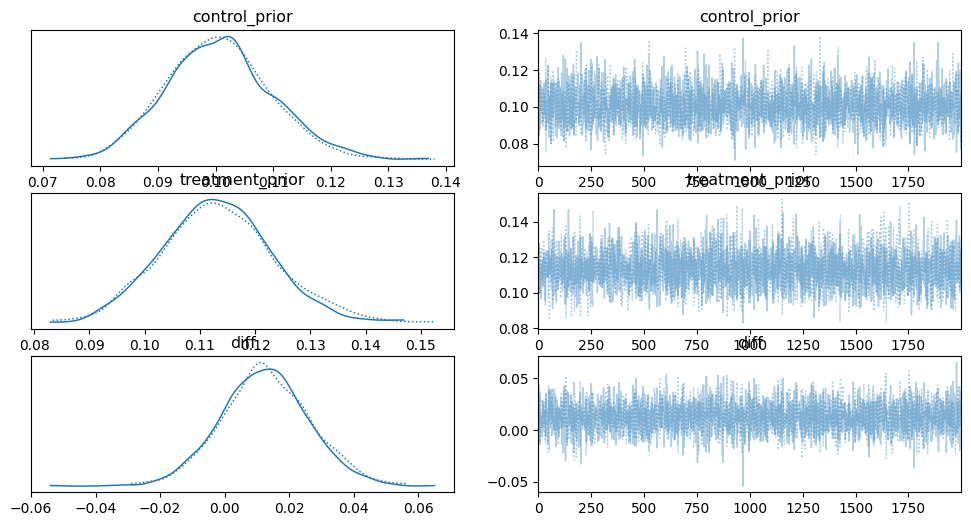

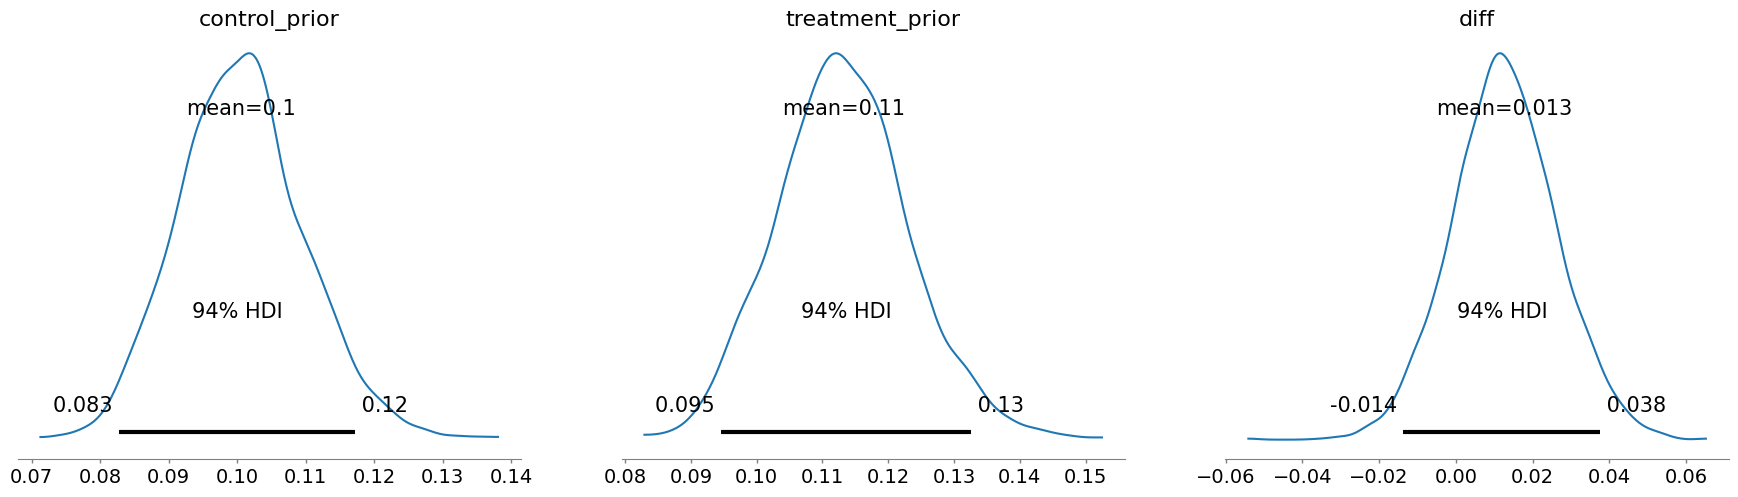

In [20]:
# Bayesian A/B testing
with pm.Model() as model:
    # Prior distribution for conversion rates (Beta distribution)
    control_prior = pm.Beta('control_prior', alpha=1, beta=1)
    treatment_prior = pm.Beta('treatment_prior', alpha=1, beta=1)

    # Likelihood function (Binomial likelihood)
    control_likelihood = pm.Binomial('control_likelihood', n=len(control_data), p=control_prior, observed=data['Control'].sum())
    treatment_likelihood = pm.Binomial('treatment_likelihood', n=len(treatment_data), p=treatment_prior, observed=data['Treatment'].sum())

    # Compute the difference between conversion rates
    diff = pm.Deterministic('diff', treatment_prior - control_prior)

    # Sampling
    trace = pm.sample(2000, tune=1000, cores=1)  # Adjust tune and cores as needed

# Assumption check: Model adequacy
# Check trace plot for convergence
pm.plot_trace(trace)
plt.show()

# Summarize results
pm.summary(trace)

# Plot posterior distributions
pm.plot_posterior(trace)
plt.show()


In [24]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [31]:
trace.posterior

<xarray.Dataset>
Dimensions:          (chain: 2, draw: 2000)
Coordinates:
  * chain            (chain) int64 0 1
  * draw             (draw) int64 0 1 2 3 4 5 ... 1994 1995 1996 1997 1998 1999
Data variables:
    control_prior    (chain, draw) float64 0.1003 0.1022 ... 0.08084 0.1244
    treatment_prior  (chain, draw) float64 0.1144 0.1132 ... 0.1053 0.1303
    diff             (chain, draw) float64 0.01409 0.01104 ... 0.02449 0.005845
Attributes:
    created_at:                 2024-03-27T00:21:50.430782
    arviz_version:              0.17.1
    inference_library:          pymc
    inference_library_version:  5.11.0
    sampling_time:              4.937059640884399
    tuning_steps:               1000

In [34]:
# # Extract posterior samples from the trace
# control_samples = trace.posterior.control_prior
# treatment_samples = trace.posterior.treatment_prior
# diff_samples = trace.posterior.treatment_prior.diff

# Extract posterior samples from the trace
control_samples = trace.posterior['control_prior'].values.flatten()
treatment_samples = trace.posterior['treatment_prior'].values.flatten()
diff_samples = trace.posterior['diff'].values.flatten()

# Compute the probability that treatment is better than control
prob_treatment_better = np.mean(diff_samples > 0)

# Compute the 95% credible interval for the difference in conversion rates
credible_interval = np.percentile(diff_samples, [2.5, 97.5])

# Print results
print("Probability that treatment is better than control:", prob_treatment_better)
print("95% credible interval for the difference in conversion rates:", credible_interval)


Probability that treatment is better than control: 0.82975
95% credible interval for the difference in conversion rates: [-0.01369093  0.04002261]


Explanation of the Code :

Let's break down the code and understand how Bayesian A/B testing is conducted:

1) Prior distribution for conversion rates:

Two prior distributions (control_prior and treatment_prior) are defined using the Beta distribution. The Beta distribution is commonly used to model proportions or probabilities, making it suitable for representing conversion rates.
The parameters alpha and beta of the Beta distribution are both set to 1, which corresponds to a uniform prior distribution over the interval [0, 1]. This means that we have no prior information about the conversion rates and treat all values equally likely a priori.

2) Likelihood function:

Binomial likelihood functions (control_likelihood and treatment_likelihood) are defined to model the observed data for the control and treatment groups, respectively.
The likelihood functions use the observed number of conversions (data['Control'].sum() and data['Treatment'].sum()) as the number of successes (k) and the total number of trials (n) as the number of trials, with the conversion rates (p) determined by the prior distributions.

3) Compute the difference between conversion rates:

A deterministic variable diff is defined to compute the difference between the conversion rates of the treatment and control groups. This allows us to directly analyze the difference in conversion rates between the two variations.

4) Sampling:

MCMC sampling is performed using the pm.sample() function. The trace variable contains the posterior samples generated by the sampling process.
The tune parameter specifies the number of tuning steps, and the cores parameter specifies the number of CPU cores to use for sampling.


After running the code, the trace object contains samples from the joint posterior distribution of all parameters in the model, including the conversion rates for the control and treatment groups. These samples can be used to compute summary statistics, generate posterior plots, and make inferences about the differences between the variations.

For decision-making in Bayesian A/B testing, you can analyze the posterior samples to estimate quantities of interest, such as the probability that the treatment group's conversion rate is higher than the control group's conversion rate. You can also compute credible intervals for the difference in conversion rates and assess whether the treatment is statistically significantly better than the control based on your decision criteria. Additionally, you may want to consider practical significance and other relevant factors when making decisions based on the results of Bayesian A/B testing.






